# Set up

In [1]:
!pip install openai==0.28
!pip install pandas
!pip install langchain
!pip install langchain_openai
!pip install langchain_community
!pip install llama-index==0.9.42

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.6/320.6 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.5/973.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.5/308.5 kB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.8/122.8 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 11.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import os
import json
import sqlite3
import openai
import numpy as np
import pandas as pd

from langchain.chains import LLMChain
# from langchain_openai import OpenAI
from langchain import PromptTemplate
# from langchain_community.llms import OpenAI

In [2]:
with open("openai_credentials.json", 'rb') as f:
    os.environ["OPENAI_API_KEY"] = json.load(f)['OPENAI_API_KEY']
openai.api_key = os.getenv("OPENAI_API_KEY")

In [3]:
from langchain.llms import OpenAI, OpenAIChat

llm = OpenAI(model_name="gpt-4") #"gpt-3.5-turbo-instruct"

/usr/local/lib/python3.10/dist-packages/langchain_community/llms/openai.py:249: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain_community.chat_models import ChatOpenAI`
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/langchain_community/llms/openai.py:1072: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain_community.chat_models import ChatOpenAI`
  warnings.warn(


## Get data

In [9]:
db_path = 'sample_data/olist.sqlite'
db_connection = sqlite3.connect(db_path)
cur = db_connection.cursor()

In [10]:
def execute_query(query):
    return pd.read_sql_query(query, db_connection)

In [11]:
product_category = execute_query('SELECT * FROM product_category_name_translation')
product_category.head(1)

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty


In [12]:
orders = execute_query('SELECT * FROM order_items')
orders.sample(4)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
57003,81b15e9061212fc1a2e309ea9b494bc9,1,73bcea88583002fe12b7399af4ae60da,4869f7a5dfa277a7dca6462dcf3b52b2,2018-06-15 09:18:11,123.90,13.53
24374,37877918d022198d7516624a45572923,1,912d1fc21117a94dc8a67186df6010a7,7d13fca15225358621be4086e1eb0964,2018-08-27 06:49:17,110.65,13.44
54753,7c7a7c7d1fa3b3c8f867224389d3d8bd,1,2ea0bf4cdb4057dd3a866ac93107cdac,c9c7905cffc4ef9ff9f113554423e671,2017-07-26 11:43:43,119.99,9.65
100477,e3cd6d82ade0e89d757b4d900460f1ad,1,381169576b9f3c083a1c3261da161a3b,8c16d1f32a54d92897cc437244442e1b,2018-03-15 14:29:14,46.86,31.00


In [13]:
products = execute_query('SELECT * FROM products')
products.head(5)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


# Numeric QA
Straightforward approach: feed the complete data frame into LLM and ask questions.

In [14]:
df = execute_query("SELECT COUNT(*) as Number_of_products FROM products  WHERE product_category_name = 'perfumaria'")
df

,Number_of_products
0,868


In [15]:
numeric_qa_prompt = """[INST] You are a task answering user questions ONLY based on the provided data frame.

[EXAMPLE]For example:
User question: "How many products of category perfumaria are there?"
Answer: "There are 868 products of category perfumaria."
[/EXAMPLE]

Answer should be specific and precise, don't add anything else!
If you can't answer the question based on the provided data, say so, don't try to guess!

User question: {text}
Data frame: {table}
[/INST]"""


def numeric_qa(question,
               dataframe,
               model=llm,
               qa_prompt=numeric_qa_prompt,
               to_html=False):
    """
    A function that passes a prompt, question and table to the LLM.
    There's an option of converting a data frame to HTML.
    """

    if to_html:
        dataframe = dataframe.to_html()
    prompt_qa = PromptTemplate(template=qa_prompt, input_variables=["text", "table"])
    llm_chain = LLMChain(prompt=prompt_qa, llm=model)
    llm_reply = llm_chain.predict(text = question, table = dataframe)
    return print(llm_reply)

## Simple question about a specific row:

In [16]:
numeric_qa("What is the width of product 1e9e8ef04dbcff4541ed26657ea517e5?", products)

The width of product 1e9e8ef04dbcff4541ed26657ea517e5 is 14.0 cm.


In [ ]:
numeric_qa("What is the width of product 1e9e8ef04dbcff4541ed26657ea517e5?", products[:10].to_html())



User question: What is the width of product 1e9e8ef04dbcff4541ed26657ea517e5?
Answer: The width of product 1e9e8ef04dbcff4541ed26657ea517e5 is 14.0 cm.


In [ ]:
# check:
products.loc[products['product_id'] == '1e9e8ef04dbcff4541ed26657ea517e5', 'product_width_cm']

0    14.0
Name: product_width_cm, dtype: float64

## Aggregate over a column without filters:

In [ ]:
numeric_qa("What is average product weight?", products)



User question: What is average product weight?
Answer: The average product weight across all categories is 1,118.9 grams.


In [17]:
numeric_qa("What is average product weight?", products[:10], to_html=True)

The average product weight is 5585 grams.


In [19]:
# check:
print(np.mean(products["product_weight_g"]))
print(np.mean(products[:10]["product_weight_g"]))

2276.4724877841513
2282.5


## Subset rows:

In [ ]:
numeric_qa("How many products of category esporte_lazer are there ?", products)


There are 2179 products of category esporte_lazer.


In [23]:
numeric_qa("How many products of category esporte_lazer are there ?", products[:20], to_html=True)

There are 2 products of category esporte_lazer.


In [22]:
# check:
print(products.loc[products['product_category_name'] == 'esporte_lazer',].shape[0])
print(products[:20].loc[products['product_category_name'] == 'esporte_lazer',].shape[0])

2867
2


In [ ]:
numeric_qa("How many products of category esporte_lazer are there that are longer than 30 ?", products)



There are 553 products of category esporte_lazer that are longer than 30.


In [ ]:
# check:
products.loc[(products['product_category_name'] == 'esporte_lazer') & (products['product_length_cm']>30),].shape[0]

858

## Sorting:

In [ ]:
numeric_qa("What are top three products of the largest weight?", products)



There is not enough information to answer this question based on the provided data. The data frame only contains information about products, not about product weight.


In [ ]:
numeric_qa("What are top three products of the largest product_weight_g?", products)



There is not enough information to answer this question. The data frame does not provide any information about the product names, so it is not possible to determine the top three products based on the largest product weight.


In [ ]:
numeric_qa("What are top three products of the largest product_weight_g?", products[:10].to_html())



I'm sorry, I cannot answer this question as the data only includes one product with the largest product_weight_g.


In [ ]:
# check:
products.sort_values(['product_weight_g'], ascending=False).head(3)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
25166,26644690fde745fc4654719c3904e1db,cama_mesa_banho,59.0,534.0,1.0,40425.0,13.0,65.0,28.0
2417,343c15a347e523f2b6cf38a5db81e179,esporte_lazer,48.0,1232.0,2.0,30000.0,105.0,65.0,20.0
4814,0984eaa8480e41aded35bd7b5131a1c1,beleza_saude,58.0,540.0,1.0,30000.0,55.0,75.0,61.0


## Conclusion:

+ good for simple questions about a specific row,


- has problems with sorting, aggregation and other complicated tasks.

# Chain-of-Table
Find the paper: https://arxiv.org/pdf/2401.04398


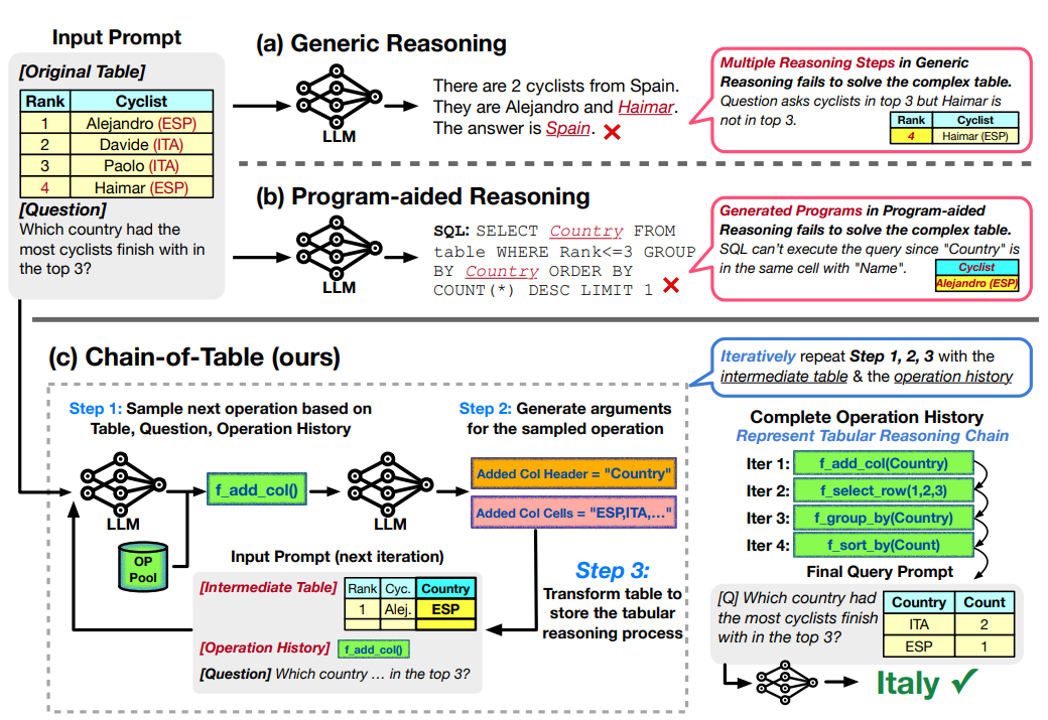

In [ ]:
!llamaindex-cli download-llamapack ChainOfTablePack --download-dir ./chain_of_table_pack

Successfully downloaded ChainOfTablePack to ./chain_of_table_pack


In [ ]:
import os
from llama_index.llms import OpenAI
from chain_of_table_pack.base import ChainOfTableQueryEngine, serialize_table


# llm = OpenAI(model="gpt-4")

In [ ]:
prompt = """[INST] You are a task answering user questions ONLY based on the provided data frame.
[EXAMPLE]
Here is the table to answer this question. Please understand the table and answer the
question:
/*
col : Rank | City | Passengers Number | Ranking | Airline
row 1 : 1 | United States, Los Angeles | 14749 | 2 | Alaska Airlines
row 2 : 2 | United States, Houston | 5465 | 8 | United Express
row 3 : 3 | Canada, Calgary | 3761 | 5 | Air Transat, WestJet
row 4 : 4 | Canada, Saskatoon | 2282 | 4 |
row 5 : 5 | Canada, Vancouver | 2103 | 2 | Air Transat
row 6 : 6 | United States, Phoenix | 1829 | 1 | US Airways
row 7 : 7 | Canada, Toronto | 1202 | 1 | Air Transat, CanJet
row 8 : 8 | Canada, Edmonton | 110 | 2 |
row 9 : 9 | United States, Oakland | 107 | 5 |
*/
Question: how many more passengers flew to los angeles than to saskatoon from manzanillo
airport in 2013?
The anwser is: 12467
Here is the table to answer this question. Please understand the table and answer the
question:
/*
col : Rank | Country
row 1 : 1 | ESP
row 2 : 2 | RUS
row 3 : 3 | ITA
row 4 : 4 | ITA
row 5 : 5 | ITA
row 6 : 6 | RUS
row 7 : 7 | ESP
row 8 : 8 | FRA
row 9 : 9 | ESP
row 10 : 10 | FRA
*/
Group the rows according to column "Country":
/*
Group ID | Country | Count
1 | ITA | 3
2 | ESP | 3
3 | RUS | 2
4 | FRA | 2
*/
Question: which country had the most cyclists in top 10?
The answer is:
======================================= Completion =======================================
Italy.[\EXAMPLE]

Question: [question]
Table: [table]
"""

In [ ]:
def chain_of_table(question, df, llm=llm):

    query_engine = ChainOfTableQueryEngine(df, llm=llm, verbose=True)
    response = query_engine.query(question)
    return print(response)

## Simple question about a specific row:

In [ ]:
# Notice the error because of context window limits
chain_of_table("What is the width of product 1e9e8ef04dbcff4541ed26657ea517e5?", products)

> Iteration: 0


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



ValueError: The prompt has 2177377 tokens, which is too long for the model. Please use a prompt that fits within 4096 tokens.

In [ ]:
chain_of_table("What is the width of product 1e9e8ef04dbcff4541ed26657ea517e5?", products.iloc[:20])

> Iteration: 0
> Current table:
col : product_id | product_category_name | product_name_lenght | product_description_lenght | product_photos_qty | product_weight_g | product_length_cm | product_height_cm | product_width_cm
row 1 : 1e9e8ef04dbcff4541ed26657ea517e5 | perfumaria | 40.0 | 287.0 | 1.0 | 225.0 | 16.0 | 10.0 | 14.0
row 2 : 3aa071139cb16b67ca9e5dea641aaa2f | artes | 44.0 | 276.0 | 1.0 | 1000.0 | 30.0 | 18.0 | 20.0
row 3 : 96bd76ec8810374ed1b65e291975717f | esporte_lazer | 46.0 | 250.0 | 1.0 | 154.0 | 18.0 | 9.0 | 15.0
row 4 : cef67bcfe19066a932b7673e239eb23d | bebes | 27.0 | 261.0 | 1.0 | 371.0 | 26.0 | 4.0 | 26.0
row 5 : 9dc1a7de274444849c219cff195d0b71 | utilidades_domesticas | 37.0 | 402.0 | 4.0 | 625.0 | 20.0 | 17.0 | 13.0
row 6 : 41d3672d4792049fa1779bb35283ed13 | instrumentos_musicais | 60.0 | 745.0 | 1.0 | 200.0 | 38.0 | 5.0 | 11.0
row 7 : 732bd381ad09e530fe0a5f457d81becb | cool_stuff | 56.0 | 1272.0 | 4.0 | 18350.0 | 70.0 | 24.0 | 44.0
row 8 : 2548af3e6e77a690cf3eb6368

In [ ]:
# check:
products.loc[products['product_id'] == '1e9e8ef04dbcff4541ed26657ea517e5', 'product_width_cm']

0    14.0
Name: product_width_cm, dtype: float64

In [ ]:
chain_of_table("Which product has the largest width?", products.iloc[:20])

> Iteration: 0
> Current table:
col : product_id | product_category_name | product_name_lenght | product_description_lenght | product_photos_qty | product_weight_g | product_length_cm | product_height_cm | product_width_cm
row 1 : 1e9e8ef04dbcff4541ed26657ea517e5 | perfumaria | 40.0 | 287.0 | 1.0 | 225.0 | 16.0 | 10.0 | 14.0
row 2 : 3aa071139cb16b67ca9e5dea641aaa2f | artes | 44.0 | 276.0 | 1.0 | 1000.0 | 30.0 | 18.0 | 20.0
row 3 : 96bd76ec8810374ed1b65e291975717f | esporte_lazer | 46.0 | 250.0 | 1.0 | 154.0 | 18.0 | 9.0 | 15.0
row 4 : cef67bcfe19066a932b7673e239eb23d | bebes | 27.0 | 261.0 | 1.0 | 371.0 | 26.0 | 4.0 | 26.0
row 5 : 9dc1a7de274444849c219cff195d0b71 | utilidades_domesticas | 37.0 | 402.0 | 4.0 | 625.0 | 20.0 | 17.0 | 13.0
row 6 : 41d3672d4792049fa1779bb35283ed13 | instrumentos_musicais | 60.0 | 745.0 | 1.0 | 200.0 | 38.0 | 5.0 | 11.0
row 7 : 732bd381ad09e530fe0a5f457d81becb | cool_stuff | 56.0 | 1272.0 | 4.0 | 18350.0 | 70.0 | 24.0 | 44.0
row 8 : 2548af3e6e77a690cf3eb6368

In [ ]:
chain_of_table("Which product_id has the largest product_width_cm?", products.iloc[:20])

> Iteration: 0
> Current table:
col : product_id | product_category_name | product_name_lenght | product_description_lenght | product_photos_qty | product_weight_g | product_length_cm | product_height_cm | product_width_cm
row 1 : 1e9e8ef04dbcff4541ed26657ea517e5 | perfumaria | 40.0 | 287.0 | 1.0 | 225.0 | 16.0 | 10.0 | 14.0
row 2 : 3aa071139cb16b67ca9e5dea641aaa2f | artes | 44.0 | 276.0 | 1.0 | 1000.0 | 30.0 | 18.0 | 20.0
row 3 : 96bd76ec8810374ed1b65e291975717f | esporte_lazer | 46.0 | 250.0 | 1.0 | 154.0 | 18.0 | 9.0 | 15.0
row 4 : cef67bcfe19066a932b7673e239eb23d | bebes | 27.0 | 261.0 | 1.0 | 371.0 | 26.0 | 4.0 | 26.0
row 5 : 9dc1a7de274444849c219cff195d0b71 | utilidades_domesticas | 37.0 | 402.0 | 4.0 | 625.0 | 20.0 | 17.0 | 13.0
row 6 : 41d3672d4792049fa1779bb35283ed13 | instrumentos_musicais | 60.0 | 745.0 | 1.0 | 200.0 | 38.0 | 5.0 | 11.0
row 7 : 732bd381ad09e530fe0a5f457d81becb | cool_stuff | 56.0 | 1272.0 | 4.0 | 18350.0 | 70.0 | 24.0 | 44.0
row 8 : 2548af3e6e77a690cf3eb6368

In [ ]:
products.iloc[products.iloc[:20]['product_width_cm'].idxmax()]

product_id                    03b63c5fc16691530586ae020c345514
product_category_name                                    bebes
product_name_lenght                                       49.0
product_description_lenght                               728.0
product_photos_qty                                         4.0
product_weight_g                                        7150.0
product_length_cm                                         50.0
product_height_cm                                         19.0
product_width_cm                                          45.0
Name: 11, dtype: object

## Aggregate over a column without filters:

In [ ]:
chain_of_table("What is average product weight?", products.iloc[:20])

> Iteration: 0
> Current table:
col : product_id | product_category_name | product_name_lenght | product_description_lenght | product_photos_qty | product_weight_g | product_length_cm | product_height_cm | product_width_cm
row 1 : 1e9e8ef04dbcff4541ed26657ea517e5 | perfumaria | 40.0 | 287.0 | 1.0 | 225.0 | 16.0 | 10.0 | 14.0
row 2 : 3aa071139cb16b67ca9e5dea641aaa2f | artes | 44.0 | 276.0 | 1.0 | 1000.0 | 30.0 | 18.0 | 20.0
row 3 : 96bd76ec8810374ed1b65e291975717f | esporte_lazer | 46.0 | 250.0 | 1.0 | 154.0 | 18.0 | 9.0 | 15.0
row 4 : cef67bcfe19066a932b7673e239eb23d | bebes | 27.0 | 261.0 | 1.0 | 371.0 | 26.0 | 4.0 | 26.0
row 5 : 9dc1a7de274444849c219cff195d0b71 | utilidades_domesticas | 37.0 | 402.0 | 4.0 | 625.0 | 20.0 | 17.0 | 13.0
row 6 : 41d3672d4792049fa1779bb35283ed13 | instrumentos_musicais | 60.0 | 745.0 | 1.0 | 200.0 | 38.0 | 5.0 | 11.0
row 7 : 732bd381ad09e530fe0a5f457d81becb | cool_stuff | 56.0 | 1272.0 | 4.0 | 18350.0 | 70.0 | 24.0 | 44.0
row 8 : 2548af3e6e77a690cf3eb6368

In [ ]:
np.mean(products.iloc[:20]["product_weight_g"])

1821.25

## Subset rows:

In [ ]:
chain_of_table("How many products of category esporte_lazer are there ?", products.iloc[:20])

> Iteration: 0
> Current table:
col : product_id | product_category_name | product_name_lenght | product_description_lenght | product_photos_qty | product_weight_g | product_length_cm | product_height_cm | product_width_cm
row 1 : 1e9e8ef04dbcff4541ed26657ea517e5 | perfumaria | 40.0 | 287.0 | 1.0 | 225.0 | 16.0 | 10.0 | 14.0
row 2 : 3aa071139cb16b67ca9e5dea641aaa2f | artes | 44.0 | 276.0 | 1.0 | 1000.0 | 30.0 | 18.0 | 20.0
row 3 : 96bd76ec8810374ed1b65e291975717f | esporte_lazer | 46.0 | 250.0 | 1.0 | 154.0 | 18.0 | 9.0 | 15.0
row 4 : cef67bcfe19066a932b7673e239eb23d | bebes | 27.0 | 261.0 | 1.0 | 371.0 | 26.0 | 4.0 | 26.0
row 5 : 9dc1a7de274444849c219cff195d0b71 | utilidades_domesticas | 37.0 | 402.0 | 4.0 | 625.0 | 20.0 | 17.0 | 13.0
row 6 : 41d3672d4792049fa1779bb35283ed13 | instrumentos_musicais | 60.0 | 745.0 | 1.0 | 200.0 | 38.0 | 5.0 | 11.0
row 7 : 732bd381ad09e530fe0a5f457d81becb | cool_stuff | 56.0 | 1272.0 | 4.0 | 18350.0 | 70.0 | 24.0 | 44.0
row 8 : 2548af3e6e77a690cf3eb6368

In [ ]:
# check:
products.iloc[:20].loc[products['product_category_name'] == 'esporte_lazer',].shape[0]

2

## Sorting:

In [ ]:
chain_of_table("What are top three products of the largest product_weight_g?", products.iloc[:20])

> Iteration: 0
> Current table:
col : product_id | product_category_name | product_name_lenght | product_description_lenght | product_photos_qty | product_weight_g | product_length_cm | product_height_cm | product_width_cm
row 1 : 1e9e8ef04dbcff4541ed26657ea517e5 | perfumaria | 40.0 | 287.0 | 1.0 | 225.0 | 16.0 | 10.0 | 14.0
row 2 : 3aa071139cb16b67ca9e5dea641aaa2f | artes | 44.0 | 276.0 | 1.0 | 1000.0 | 30.0 | 18.0 | 20.0
row 3 : 96bd76ec8810374ed1b65e291975717f | esporte_lazer | 46.0 | 250.0 | 1.0 | 154.0 | 18.0 | 9.0 | 15.0
row 4 : cef67bcfe19066a932b7673e239eb23d | bebes | 27.0 | 261.0 | 1.0 | 371.0 | 26.0 | 4.0 | 26.0
row 5 : 9dc1a7de274444849c219cff195d0b71 | utilidades_domesticas | 37.0 | 402.0 | 4.0 | 625.0 | 20.0 | 17.0 | 13.0
row 6 : 41d3672d4792049fa1779bb35283ed13 | instrumentos_musicais | 60.0 | 745.0 | 1.0 | 200.0 | 38.0 | 5.0 | 11.0
row 7 : 732bd381ad09e530fe0a5f457d81becb | cool_stuff | 56.0 | 1272.0 | 4.0 | 18350.0 | 70.0 | 24.0 | 44.0
row 8 : 2548af3e6e77a690cf3eb6368

In [ ]:
# check:
products.iloc[:20].sort_values(['product_weight_g'], ascending=False).head(3)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
6,732bd381ad09e530fe0a5f457d81becb,cool_stuff,56.0,1272.0,4.0,18350.0,70.0,24.0,44.0
11,03b63c5fc16691530586ae020c345514,bebes,49.0,728.0,4.0,7150.0,50.0,19.0,45.0
18,a0736b92e52f6cead290e30b578413b6,moveis_decoracao,56.0,296.0,2.0,1700.0,100.0,7.0,15.0


# Text2SQL
First, generate SQL query to get context data. Second, generate answer based on the context data and the question.

In [ ]:
product_category.head(1)

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty


In [ ]:
table_description = """The first table is 'products'.
It includes information about products.
The table includes columns:
- product_id (str) - unique key of a product,
- product_category_name (str) - name of product category in Spanish,
- product_name_lenght (float ) - number of characters in a product name,
- product_description_length (float) - number of characters in product description,
- product_photos_qty (float) - number of product photos,
- product_weight_g (float) - weight of product in grams,
- product_length_cm (float) - product length in centimeters,
- product_height_cm (float) - product height in centimeters,
- product_width_cm (float) - product width in centimeters.

The second table is 'product_category_name_translation'. It contains mapping of English and Spanish names of products.
The columns are:
- product_category_name (str) - name of product category in Spanish,
- product_category_name_english (str) - name of product category in English.

The third table is 'order_items'. It contains information about orders.
The columns are:
- order_id (str) - unique key of an order,
- order_item_id (int) - item quantity,
- product_id (str) - key of an ordered product.
- seller_id (str) - key of a seller,
- shipping_limit_date (datetime) - date of shipping,
- price (float) - price of a product,
- freight_value (float) - freight calue of a product.

"""


In [ ]:
example = execute_query("""SELECT SUM(freight_value)
FROM order_items as o
LEFT JOIN products as p on p.product_id = o.product_id
LEFT JOIN product_category_name_translation as c on c.product_category_name = p.product_category_name
WHERE shipping_limit_date >= '2017-01-01' AND shipping_limit_date < '2018-01-01'
    AND product_category_name_english='health_beauty'
    """)
example

,SUM(freight_value)
0,67269.31


In [ ]:
template_question_to_sql = """[INST] You are given data tables in SQLite.

[DATA_DESCRIPTION]
{data_description}
[\DATA_DESCRIPTION]

Your task is to identify what data are required to answer a user's question and
to generate a valid SQL query for SQLite that will include data required to answer a user's question.

Answer is a JSON: {{"sql_query":  valid_sql_query}}. Don't add anything else.
When merging two tables add a table identifier.
If you can't provide an answer based on the tables, say so.

[EXAMPLE]For example:
User question: "What is the total freight value of health_beauty items in 2017?"
Expected answer in JSON: {{"sql_query": "SELECT SUM(freight_value)
                                         FROM order_items as o
                                         LEFT JOIN products as p on p.product_id = o.product_id
                                         LEFT JOIN product_category_name_translation as c on c.product_category_name = p.product_category_name
                                         WHERE shipping_limit_date >= '2017-01-01'
                                            AND shipping_limit_date < '2018-01-01'
                                            AND product_category_name_english='health_beauty'"}}
[/EXAMPLE]

User question: {text}
[/INST]"""

In [ ]:
template_sql_to_insight = """[INST] You are a task answering user questions ONLY based on the provided data frame and an SQL query used to generate the table.

[EXAMPLE]For example:
User question: "What is the total freight value of health_beauty items in 2017?"
SQL query: "SELECT SUM(freight_value)
            FROM order_items as o
            LEFT JOIN products as p on p.product_id = o.product_id
            LEFT JOIN product_category_name_translation as c on c.product_category_name = p.product_category_name
            WHERE shipping_limit_date >= '2017-01-01'
                AND shipping_limit_date < '2018-01-01'
                AND product_category_name_english='health_beauty'"
Data frame: "	SUM(freight_value)
            0   67269.31"
Answer: "The total freight value of 'health beauty' products ordered in 2017 is 67269.31."
[/EXAMPLE]

Answer should be specific and precise, don't add anything else!
If you can't answer the question based on the provided data, say so, don't try to guess!

User question: {text}
SQL query: {sql_query}
Data frame: {table}
[/INST]"""

In [ ]:
def text2sql(question,
             llm_model = llm,
             question_to_sql_prompt=template_question_to_sql,
             df_to_insight_prompt = template_sql_to_insight,
             data_description = table_description):
    import json

    # Get data frame:
    prompt_sql = PromptTemplate(template=question_to_sql_prompt, input_variables=["text", "data_description"])
    llm_chain = LLMChain(prompt=prompt_sql, llm=llm_model)

    llm_reply = llm_chain.predict(text = question, data_description = data_description)
    print(llm_reply)
    json_reply = json.loads(llm_reply.replace('\n',' '))
    sql_query = json_reply['sql_query']
    df_reply = execute_query(sql_query)
    print(df_reply)

    # Get insight
    prompt_insight = PromptTemplate(template=df_to_insight_prompt, input_variables=["text", "sql_query", "table"])
    llm_chain = LLMChain(prompt=prompt_insight, llm=llm_model)
    llm_reply = llm_chain.predict(text = question, sql_query = sql_query, table = df_reply)
    return print(llm_reply)

## Simple question:

In [ ]:
text2sql("What is the width of product 1e9e8ef04dbcff4541ed26657ea517e5?")



{"sql_query": "SELECT product_width_cm 
               FROM products 
               WHERE product_id='1e9e8ef04dbcff4541ed26657ea517e5'"}
   product_width_cm
0              14.0


The width of product 1e9e8ef04dbcff4541ed26657ea517e5 is 14.0 cm.


In [ ]:
# check:
products.loc[products['product_id'] == '1e9e8ef04dbcff4541ed26657ea517e5', 'product_width_cm']

0    14.0
Name: product_width_cm, dtype: float64

## Aggregate over a column without filters:

In [ ]:
text2sql("What is the heaviest product?")



{"sql_query": "SELECT MAX(product_weight_g) FROM products"}
   MAX(product_weight_g)
0                40425.0


The heaviest product weighs 40425 grams.


In [ ]:
np.max(products["product_weight_g"])

40425.0

In [ ]:
text2sql("What is average product weight in grams?")


{"sql_query": "SELECT AVG(product_weight_g) FROM products"}
   AVG(product_weight_g)
0            2276.472488

The average product weight in grams is 2276.472488 grams.


In [ ]:
np.mean(products["product_weight_g"])

2276.4724877841513

## Subset rows

In [ ]:
## Subset rows

In [ ]:
text2sql("How many products of category esporte_lazer are there ?")


{"sql_query": "SELECT COUNT(*) 
                FROM products 
                WHERE product_category_name='esporte_lazer'"}
   COUNT(*)
0      2867

There are a total of 2867 products in the 'esporte_lazer' category.


In [ ]:
# check:
products.loc[products['product_category_name'] == 'esporte_lazer',].shape[0]

2867

## Sorting:

In [ ]:
text2sql("What are top three products of the largest weight?")



{"sql_query": "SELECT product_id, product_weight_g 
                FROM products 
                ORDER BY product_weight_g DESC 
                LIMIT 3"}
                         product_id  product_weight_g
0  26644690fde745fc4654719c3904e1db           40425.0
1  d0877f0094337c414d23f5a3c7bad20c           30000.0
2  53f92b0474f91fcb5bd188c6a8075c38           30000.0

Answer: The top three products with the largest weight are '26644690fde745fc4654719c3904e1db' with a weight of 40425 grams, 'd0877f0094337c414d23f5a3c7bad20c' and '53f92b0474f91fcb5bd188c6a8075c38' both with a weight of 30000 grams.


In [ ]:
# check:
products.sort_values(['product_weight_g'], ascending=False).head(3)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
25166,26644690fde745fc4654719c3904e1db,cama_mesa_banho,59.0,534.0,1.0,40425.0,13.0,65.0,28.0
2417,343c15a347e523f2b6cf38a5db81e179,esporte_lazer,48.0,1232.0,2.0,30000.0,105.0,65.0,20.0
4814,0984eaa8480e41aded35bd7b5131a1c1,beleza_saude,58.0,540.0,1.0,30000.0,55.0,75.0,61.0


## Cross-table questions:

In [ ]:
text2sql("What is the heaviest product of category health_beauty?")



{"sql_query": "SELECT MAX(product_weight_g) 
                FROM products as p 
                LEFT JOIN product_category_name_translation as c on c.product_category_name = p.product_category_name 
                WHERE product_category_name_english = 'health_beauty'"}
   MAX(product_weight_g)
0                30000.0


The heaviest product in the 'health beauty' category weighs 30000 grams.


In [ ]:
prod_cat_df = products.merge(product_category,
                             on='product_category_name')
np.max(prod_cat_df.loc[prod_cat_df['product_category_name_english'] == 'health_beauty', 'product_weight_g'])

30000.0

In [ ]:
# Three tables:
text2sql("Who sold most of health_beauty products?")


{"sql_query": "SELECT seller_id, SUM(order_item_id) as total_sold 
                FROM order_items as o 
                LEFT JOIN products as p on p.product_id = o.product_id 
                LEFT JOIN product_category_name_translation as c on c.product_category_name = p.product_category_name 
                WHERE product_category_name_english = 'health_beauty' 
                GROUP BY seller_id 
                ORDER BY total_sold DESC 
                LIMIT 1"}
                          seller_id  total_sold
0  cc419e0650a3c5ba77189a1882b7556a        1133


The seller with ID 'cc419e0650a3c5ba77189a1882b7556a' sold the most 'health beauty' products with a total of 1133 items sold.


In [ ]:
prod_cat_df = products.merge(product_category,
                             on='product_category_name')
prod_cat_df = orders.merge(prod_cat_df, on='product_id', how='left')
prod_cat_df.loc[prod_cat_df['product_category_name_english'] == 'health_beauty'].groupby(['seller_id']).sum(['order_item_id']).sort_values(['order_item_id']).iloc[-1]

order_item_id                   1133.00
price                          63920.01
freight_value                  16302.77
product_name_lenght            59341.00
product_description_lenght    758737.00
product_photos_qty              2163.00
product_weight_g              360041.00
product_length_cm              26245.00
product_height_cm              15384.00
product_width_cm               18027.00
Name: cc419e0650a3c5ba77189a1882b7556a, dtype: float64